In [1]:
import argparse
import os
import numpy as np
import pickle
from word_holder import build_word_holder
from pycocotools.coco import COCO
from data_loader import get_loader
import torch
from tensorboardX import SummaryWriter
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from TheRealNapster import *
from word_holder import word_holder
    

In [7]:
def unnormalize_batch(image_batch):
    inv_batch = torch.empty(image_batch.size())
    for i, image in enumerate(image_batch):
        inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                                             std=[1/0.229, 1/0.224, 1/0.225])
        orig_image = inv_normalize(image)
        inv_batch[i] = orig_image
    return inv_batch
  
    
def get_words(captions, vocab):
    sampled_caption = []
    for cap in captions:
        resampleThis = []
        for word_id in cap:
            word = vocab.idx_to_word[word_id]
            resampleThis.append(word)
            if word == '<end>':
                break
        sampled_caption.append(' '.join(resampleThis))
#     for sample in sampled_caption:
#         print(sample)
    return sampled_caption
      

def main(args, run_id):
    
    # Create SummaryWriter object for tracking using tensorboard
    writer = SummaryWriter('{0}/{1}/{2}'.format(args.tensorboard_path, run_id, args.run_id))
    
    test_transforms = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocab built from build_vocab.py
    with open('data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)

    # Load IDs that will be used for training
    with open('data/test_filtered_ids.pkl', 'rb') as f:
        IDs = pickle.load(f)

    test_dataloader = get_loader(root=args.image_path, json=args.annotation_path, 
                                  ids=IDs, vocab=vocab, transform=test_transforms,
                                  batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

    
    # Build models
    encoder = Enigma(args.embed_dim).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = Christopher(len(vocab), args.embed_dim, args.units_per_layer, args.num_layers)
    
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    encoder.load_state_dict(torch.load('models/Enigma_5-500_lr-0.001_nl-1_hls-512_es-256_bs-128_t-lstm_pte-False.ckpt'))
    decoder.load_state_dict(torch.load('models/Christopher_5-500_lr-0.001_nl-1_hls-512_es-256_bs-128_t-lstm_pte-False.ckpt'))

    for i, (image_batch, caption_batch, length_batch) in enumerate(test_dataloader):
        image_batch = image_batch.to(device)
        caption_batch = caption_batch.to(device)
        target_batch = pack_padded_sequence(caption_batch, length_batch, batch_first=True)[0]
       
        # Run through model
        encoder_features = encoder(image_batch)
        output = decoder(encoder_features, caption_batch, length_batch)
        
        # For the first batch, display how we are doing on four images
        n = 5
        if i == 0:
            un_batch = unnormalize_batch(image_batch[0:n])
            writer.add_images('Test Batch Sample', un_batch, 1)
            caption_ids = decoder.ItsGameTime(encoder_features)
            caption_ids = caption_ids[0:n].cpu().numpy() 
            caption = get_words(caption_ids, vocab)
            real_caption = get_words(vocab=vocab, captions=caption_batch[0:n].cpu().numpy())
            writer.add_text('Test Image 1 Predicted Caption', caption[0], 1)
            writer.add_text('Test Image 1 Actual Caption', real_caption[0], 1)
            writer.add_text('Test Image 2 Predicted Caption', caption[1], 2)
            writer.add_text('Test Image 2 Actual Caption', real_caption[1], 2)
            writer.add_text('Test Image 3 Predicted Caption', caption[2], 3)
            writer.add_text('Test Image 3 Actual Caption', real_caption[2], 3)            
            writer.add_text('Test Image 4 Predicted Caption', caption[3], 4)
            writer.add_text('Test Image 4 Actual Caption', real_caption[3], 4)  
            for j, (rcap, gcap) in enumerate(zip(real_caption, caption)):
                print(j + 1)
                print(rcap)
                print(gcap)
            writer.flush()
            break
            
    writer.close()

In [8]:
            
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # File structure arguments
    path_args = parser.add_argument_group('Input/output options:')
    path_args.add_argument('--run_id', type=str, default='test', help='tensorboard subdirectory')
    path_args.add_argument('--tensorboard_path', type=str, default='tensorboard_kk', help='Directory for Tensorboard output')
    path_args.add_argument('--model_path', type=str, default='models', help='Directory for saved model checkpoints')
    path_args.add_argument('--image_path', type=str, default='data/images/test_resized', help='Directory with test images')
    path_args.add_argument('--annotation_path', type=str, default='data/annotations/captions_val2014.json', help='Directory with training annotations')
    
    # Model structure arguments
    model_args = parser.add_argument_group('Model structure options:')
    model_args.add_argument('--embed_dim', type=int, default=256, help='Dimensions of word embedding to use')
    model_args.add_argument('--num_layers', type=int, default=1, help='Number of hidden layers in model')
    model_args.add_argument('--units_per_layer', type=int, default=512, help='Number of hidden units in each hidden layer')
    model_args.add_argument('--unit_type', type=str, default='lstm', help='Defines unit, either lstm or rnn')
    model_args.add_argument('--pretrained_embedding', type=bool, default=False, help='Boolean flag for pretrained embeddings')
    
    # Training arguments
    training_args = parser.add_argument_group('Training options:')
    training_args.add_argument('--batch_size', type=int, default=128, help='Batch size for mini-batch gradient descent')
    training_args.add_argument('--num_workers', type=int, default=2, help='Number of workers for dataloading')
    training_args.add_argument('--validation_split', type=float, default=0.2, help='Validation split percentage for training')
    training_args.add_argument('--num_epochs', type=int, default=5, help='Number of epochs to train on')
    training_args.add_argument('--learning_rate', type=float, default=0.001, help='Set learning rate for training')
    
    # Logging arguments
    log_args = parser.add_argument_group('Logging options:')
    log_args.add_argument('--log_step', type=int, default=10, help='Number of batches between printing status')
    log_args.add_argument('--save_step', type=int, default=250, help='Number of batches between saving models')
                           
    args = parser.parse_args([])
    
    run_id = 'lr-{0}_nl-{1}_hls-{2}_es-{3}_bs-{4}_t-{5}_pte-{6}_resize'.format(args.learning_rate, args.num_layers,
                                                                        args.units_per_layer, args.embed_dim,
                                                                        args.batch_size, args.unit_type,
                                                                        args.pretrained_embedding)
                           
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    main(args, run_id)

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
Not pre-initializing...
Using lstm model...
1
<start> a boat is docked and filled with bicycles next to a grassy area on a body of water . <end>
<start> a boat is parked in a lot of water . <end>
2
<start> a broken door frame showing a a bathroom with a cement floor and a broken back wall <end>
<start> a cat sitting on top of a toilet in a bathroom . <end>
3
<start> a gray car driving by a city bus on the opposite side of the street . <end>
<start> a bus driving down a street next to a building . <end>
4
<start> an outside doorway to a restroom showing a destroyed wall and damaged floor . <end>
<start> a cat is sitting on the ground in a bathroom . <end>
5
<start> a grey and white cat standing in the grass in a parking lot . <end>
<start> a dog sitting on the ground next to a truck . <end>


In [3]:
test_transforms = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
with open('data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)

    # Load IDs that will be used for training
with open('data/test_filtered_ids.pkl', 'rb') as f:
        IDs = pickle.load(f)


t_dataloader = get_loader(root=args.image_path, json=args.annotation_path, 
                                  ids=IDs, vocab=vocab, transform=test_transforms,
                                  batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [4]:
for i, (image_batch, caption_batch, length_batch) in enumerate(t_dataloader):
    break

In [5]:
image_batch.size()

torch.Size([128, 3, 200, 200])

In [6]:
img_batch_np = unnormalize_batch(image_batch).cpu().numpy()
img_batch_np = img_batch_np.transpose((0, 2, 3, 1))
img_batch_np.shape

(128, 200, 200, 3)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img_batch_np[2])

NameError: name 'img_batch_np' is not defined

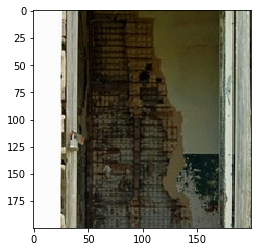

In [9]:
plt.imshow(img_batch_np[3])

In [12]:
(img_batch_np[1] != img_batch_np[3]).sum()

115454

In [18]:
get_words(vocab=vocab, captions=caption_batch.cpu().numpy())

<start> a boat is docked and filled with bicycles next to a grassy area on a body of water . <end>
<start> a broken door frame showing a a bathroom with a cement floor and a broken back wall <end>
<start> a gray car driving by a city bus on the opposite side of the street . <end>
<start> an outside doorway to a restroom showing a destroyed wall and damaged floor . <end>
<start> a grey and white cat standing in the grass in a parking lot . <end>
<start> an airplane on the runway either just landed or ready to take off . <end>
<start> a baseball player <err> head next to two computer monitors on a desk . <end>
<start> a close of a <err> head doll with a computer in the background . <end>
<start> a man riding a dirt bike is airborne after hitting a small jump . <end>
<start> motorcycle rider in the middle of the air while riding a dirt bike . <end>
<start> a bicyclist is riding across the street next to someone on a motorcycle . <end>
<start> a public restroom with two sinks and a paper t

['<start> a boat is docked and filled with bicycles next to a grassy area on a body of water . <end>',
 '<start> a broken door frame showing a a bathroom with a cement floor and a broken back wall <end>',
 '<start> a gray car driving by a city bus on the opposite side of the street . <end>',
 '<start> an outside doorway to a restroom showing a destroyed wall and damaged floor . <end>',
 '<start> a grey and white cat standing in the grass in a parking lot . <end>',
 '<start> an airplane on the runway either just landed or ready to take off . <end>',
 '<start> a baseball player <err> head next to two computer monitors on a desk . <end>',
 '<start> a close of a <err> head doll with a computer in the background . <end>',
 '<start> a man riding a dirt bike is airborne after hitting a small jump . <end>',
 '<start> motorcycle rider in the middle of the air while riding a dirt bike . <end>',
 '<start> a bicyclist is riding across the street next to someone on a motorcycle . <end>',
 '<start> 

In [1]:
caption_batch[0]

NameError: name 'caption_batch' is not defined